# GMM clustering to generate the most likely elevation for a X, Y georeferenced dataset (Z unknown)

## trained on a X, Y, Z georeferenced  training set

This is a first draft and any inputs or feedback are more than welcomed !

Typical application: you have a recent dataset with X,Y, Z and you want to add older data only "georeferenced" as dots on a map (comparable to X, Y coordinates if you work it out with free softwares such as QGis).
Using the fully georeferenced dataset (training data), you can predict the most likely elevation for the partially georeferenced data

Let's first import what is needed

In [181]:
import csv
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")


from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import sklearn.mixture as mix


In [182]:
import matplotlib.font_manager
matplotlib.rcParams.update({'font.size': 20})
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

This being done, we can start importing the datasets: "training_topo.csv" contains X, Y, Z coordinates and "incomplete_topo.csv" just the data with X, Y coordinates.

In [183]:
import requests
from os import getcwd

url_train = "https://raw.github.com/AntoineHeu/Small_hacks/master/training_topo.csv"
url_test="https://raw.github.com/AntoineHeu/Small_hacks/master/incomplete_topo.csv"
directory = getcwd()


geo_ref=pd.read_csv(url_train,sep=',',encoding = "ISO-8859-1")
geo_incomplete=pd.read_csv(url_test,sep=',',encoding = "ISO-8859-1")

Let's have a quick look to the data, just to check if everything is alright. Datasets are already cleaned-up here so no need to go through assignation of missing values etc.

In [184]:
geo_ref.head()


,sondages,X,Y,Z
0,S1,652007.83,1736990.25,4.08
1,S2,651983.68,1736997.25,4.26
2,S3,651997.93,1736991.36,4.24
3,S4,651986.97,1737006.26,4.02
4,S5,651939.91,1736921.79,4.20


In [185]:
geo_incomplete.head()

,sondages,X,Y,Z
0,SP10-1,651925.403692,1.737052e+06,NaN
1,SP4-2,651954.040791,1.737028e+06,NaN
2,SP4-3,651961.486437,1.737038e+06,NaN
3,SP16-4,651947.167887,1.737011e+06,NaN
4,SP16-5,651954.327162,1.737014e+06,NaN


As expected, the incomplete dataset is missing Z values - this is what we are trying to predict here!

Here we go for the real game. Let's remind what the objectives are:

The ideal clusters will take into consideratiion:
- The X, Y repartition of the data / two close points are likely to have similar elevation
- The clusters are supposed to minimize the standard deviation of Z within them (meaning that members within a cluster are expected to show a minimal of variety of Z values)

### 1. Defining the functions needed
Let's first program the function that scores according to the standard deviation within each cluster.
This function returns the average standard deviation. The smaller, the better !

In [186]:
def home_weighted_scoring(dataframe,target,clusters):
    
    #function that performs a scoring according to how well clusters will group points of similar levels
    
    #####
    #dataframe is a dataframe of the data
    #target is the elevation of the clustered samples
    #clusters are the clusers assigned to each sample
    #####
    
    #dictionnary containing the results
    dct=dict()

    for rows in range(len(dataframe)):
        if dataframe[clusters][rows] not in dct.keys():
            dct[dataframe[clusters][rows]]=[dataframe[target][rows]]

        else:
            dct[dataframe[clusters][rows]].append(dataframe[target][rows])
    
    #Calculate the standard deviation in each cluster
    def std_heights(dictionnary,key):
        liste = dictionnary[key]
        import statistics
        try:
            std=statistics.stdev(liste)
        except:
            std=0
        
        
        return std
    
    final_score=0
    
    for keys in dct.keys():
        scoring=std_heights(dct,keys)
        final_score=final_score+ scoring
    final_score=final_score/len(dct.keys())
        
    return final_score

This done, we can focus on the basic function that will train the clustering algorithm.
I have coded this function to broader utilisations than the one here - meaning that there are additionnal option such as a PCA (mostly for visualisation of large datasets) - here this options are not used.

I also left as comments the possibility to check for other clustering algorithms (here Kmeans, or Spectral clustering).
Again, here we'll stick to the Gaussian Mixture which has a lot of interesting properties (such as the generation of data for example !)

In [187]:
def clust_model_training(data,pred,nom_ref,list_lithos,n_clusters,cv_type='full',pca=False,n_comp=2):
    
     #function that trains a clustering algorithm
    #return a dataset with the samples and their dominant lithology
    
    #####
    #data is the dataframe containing the training data
    #pred is the list of names for the predictors
    #list_lithos is the list of columns names for the lithologies
    #nom_ref is the name of the column containing sample references
    #n_clusters is the number of clusters to compute
    #cv_type is the type of covariance (for GM algo)
    #pca=True or False if a PCA is to be computed on the predictors (allows the visualisation of clusters and data, etc..)
    #n_comp is the number of components to consider if pca is activated
    #####
    
    
    final_df=pd.DataFrame()
    
    'built in of predictors'
    clean_up=pd.DataFrame()
    for i in pred:
        clean_up=pd.concat([clean_up,data[i]],axis=1)
        clean_up_scale=clean_up
    for j in list_lithos:
        clean_up=pd.concat([clean_up,data[j]],axis=1)
    
    clean_up=pd.concat([clean_up,data[nom_ref]],axis=1)
    
    clean_up.dropna(inplace=True)
    clean_up_scale.dropna(inplace=True)
    clean_up.index = pd.RangeIndex(len(clean_up.index))
    clean_up_scale.index = pd.RangeIndex(len(clean_up_scale.index))

    predictors=pd.DataFrame()
    for i in pred:
        predictors=pd.concat([predictors,clean_up[i]],axis=1)
    list_pred=list(predictors.columns)
    
    predictors.index = pd.RangeIndex(len(predictors.index))

    predictors=pd.DataFrame(predictors)
    predictors.columns=list_pred       
    
    if pca==True:
        predictors=dim_reduction_pca(predictors,n_comp)

    #kmeans = KMeans(n_clusters=n_clusters)
    #kmeans=SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',assign_labels='kmeans')
    kmeans=mix.GaussianMixture(n_components=n_clusters, covariance_type = cv_type)

    try:
        y_kmeans = kmeans.fit_predict(predictors)
    except:
        y_kmeans = kmeans.fit(predictors).predict(predictors)
    
    final_df=pd.concat([final_df,pd.DataFrame(y_kmeans),data[nom_ref],data[list_lithos]],axis=1)
    final_df.columns=['clusters','sam_ref','hauteur']
    
    return final_df,predictors,kmeans, y_kmeans

Great, so far we have a scoring function and the function that will train our clustering model for a given number of clusters and covariance type.

We now need to find the best parameters !

### 2. Finding the optimal number of clusters and covariance type (for GM)

Let's use the great algotithm available here:
http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html

all credit goes to them - I just added a few modifications such as our home-made scoring

I like this function because it gives quite a few informations:
- it will plot the X,Y coordinates which will allow you to check if everuthing is running fine
- it compares different covariance strategies and different number of clusters

This function will select the best combination of (number of clusters, covariance type)

In [188]:
def test_BIC_validation_with_scoring(score=True):
    
    #BIC testing of different covariance definition and number of clusters
    #BIC scoring has been tuned to include the home_made_scoring if parameter score==True
    
    #largely extracted from scikit libraries - online examples
    #all credits goes to: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html
    #check the page for more infos
    
    #largely extracted from scikit libraries - online examples
    import numpy as np
    import itertools
    
    from scipy import linalg
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    
    from sklearn import mixture
    
    plt.clf()
    print(__doc__)
        
    # Generate random sample, two components
    np.random.seed(0)    
    
    lowest_bic = np.infty
    bic = []
    n_components_range = range(2, 15)
    # 
    cv_types = ['spherical', 'diag','full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            #house made prediction
            final_df,predictors,kmeans, cluster_model=clust_model_training(geo_ref,['X','Y'],'sondages',['Z'],n_components,cv_type,pca=False,n_comp=2)
            scoring=home_weighted_scoring(final_df,'hauteur','clusters')
            
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(predictors)
            if score==True:
                bic.append(gmm.bic(predictors)*scoring)
            else:
                bic.append(gmm.bic(predictors))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
                saved_cv=cv_type
                saved_component=n_components
    
    bic = np.array(bic)
    color_iter = itertools.cycle(['navy', 'indianred', 'cornflowerblue',
                                  'darkorange','green','orangered','peru','gold'])
    clf = best_gmm
    bars = []
    
    # Plot the BIC scores
    spl = plt.subplot(2, 1, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model')
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)
    
    if len(predictors.columns)==2:
        try:
            # Plot the winner
            splot = plt.subplot(2, 1, 2)
            Y_ = clf.predict(predictors)
    
            for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                                       color_iter)):
    
                v, w = linalg.eigh(cov)
                
                if not np.any(Y_ == i):
                    continue
                plt.scatter(np.array(predictors)[Y_ == i, 0], np.array(predictors)[Y_ == i, 1], 2.8, color=color)
    
                # Plot an ellipse to show the Gaussian component
                angle = np.arctan2(w[0][1], w[0][0])
                angle = 180. * angle / np.pi  # convert to degrees
                v = 2. * np.sqrt(2.) * np.sqrt(v)
                ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
                ell.set_clip_box(splot.bbox)
                ell.set_alpha(.5)
                splot.add_artist(ell)
            
        except:
            #somehow the graph is not plotted when the winner is not with a full covariance property... I didn't take the time to fix that :)
            print("scatter graph could not be displayed")
    
    plt.xticks(())
    plt.yticks(())
    plt.title('Selected GMM')
    plt.subplots_adjust(hspace=.35, bottom=.02)
    plt.savefig("cross_validation of parameters.png")
    plt.show()


    return saved_cv, saved_component,predictors


That being set, we are ready to give it a try with our data !

Automatically created module for IPython interactive environment


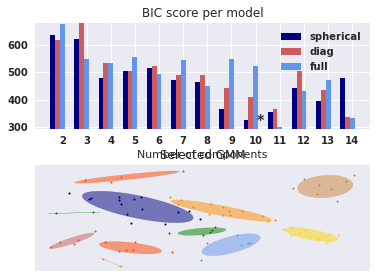

In [189]:
saved_cv, saved_component,predictors=test_BIC_validation_with_scoring(score=True)

In [190]:
saved_component,saved_cv

(11, 'full')

Ok, it's looking good - surely the graph needs a little clean-up but we got the idea:
- optimal number of clusters is 11 for a full covariance strategy
- here number of clusters assessed are limited to 15 as it seemed to be coherent for the site
- Obviously, if the number of assessed clusters were to range from 2 to number of points, the optimum would be the number of points (standard deviation of 0)

Just a point here: the graph will not be plotted if the covariance type is not "full" - there is surely something to look for in the algo but I did not take the time to fixe it. Feel free to point out the problem if you spot it !

Now, as my scoring is not built up on a solid mathematic demonstration on how well it performs, you can (and you should !) be a bit dubitative about it.

Let's plot the scores for a range of clusters from 2 to 50 with our clustering model and a covariance type "full" (each cluster has it's own covariance)

In [191]:
def plot_scorings (data,pred,nom_ref,list_lithos,cv_type='full',pca=False,n_comp=2):
    scores=[]
    n_comp=[]
    for i in range(2,50):
        final_df,predictors,kmeans, cluster_model=clust_model_training(data,pred,nom_ref,list_lithos,i,cv_type,pca,n_comp)
        final_score=home_weighted_scoring(final_df,'hauteur','clusters')
        scores.append(final_score)
        n_comp.append(i)
    
    figure = plt.figure(figsize = (10,10))
    plt.plot(n_comp, scores, color='g')
    plt.xlabel('number of clusters')
    plt.ylabel('scores')
    plt.title('scores according to the number of clusters')
    figure.savefig("%s_scoring.png"%(nom_ref))
    plt.show()
    
    return

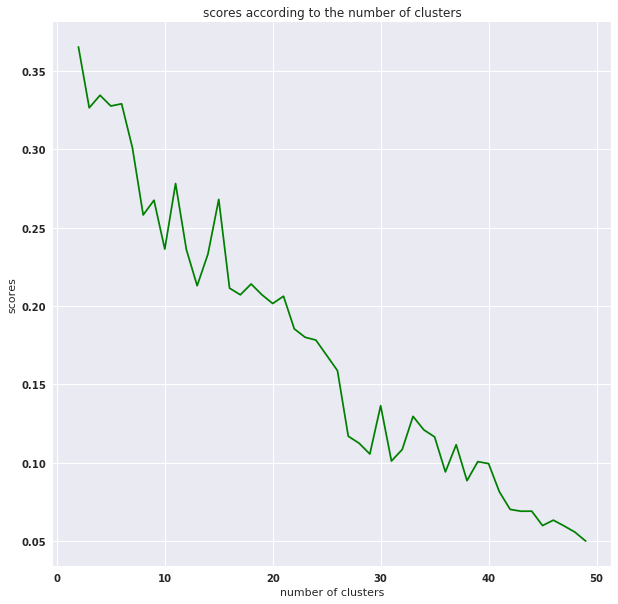

In [192]:
plot_scorings (geo_ref,['X','Y'],'sondages',['Z'],'full',pca=False,n_comp=2)

As expected, the average standard deviation decreases with the number of clusters. It is interesting to see that the optimum number of clusters is not that much influenced by the scoring as the mean standard deviation for 11 clusters is around 0.275.

There is probably room for more investigation here !

### 3. Use the model to assign elevation to the incomplete data

To use the model we optimized, we need a few basic fonctions.

The first one is the assignation of the elevation to the clusters

In [193]:
def assign_values_clusters(dataframe,target,clusters):
    
    #function that assigns, for each cluster its mean elevation
    #####
    #dataframe is a dataframe of the data
    #target is the elevation
    #clusters are the clusers assigned to each sample
    #####
    
    #dictionnary containing the results
    dct=dict()
    for rows in range(len(dataframe)):
        if dataframe[clusters][rows] not in dct.keys():
            dct[dataframe[clusters][rows]]=[dataframe[target][rows]]

        else:
            dct[dataframe[clusters][rows]].append(dataframe[target][rows])
    
    def mean_height(dictionnary,key):
        liste = dictionnary[key]
        mean=sum(liste) / float(len(liste))
        
        return mean
    
    for keys in dct.keys():
        mean_clusters=mean_height(dct,keys)
        dct[keys]=mean_clusters
    
    return dct

let's use it and show the mean elevation for each clusters

In [194]:
final_df,predictors,kmeans, cluster_model=clust_model_training(geo_ref,['X','Y'],'sondages',['Z'],11,'full',pca=False,n_comp=2)
means=assign_values_clusters(final_df,'hauteur','clusters')

In [195]:
means

{0: 4.0314285714285711,
 1: 4.1962499999999991,
 2: 4.1399999999999997,
 3: 3.48,
 4: 3.9488888888888889,
 5: 3.7039999999999993,
 6: 4.1780000000000008,
 7: 4.1733333333333338,
 8: 4.1950000000000003,
 9: 3.3149999999999999,
 10: 3.4900000000000002}

This final script built a csv file with the names of drillholes and their assigned cluster. One just has to complete it with the correspondant elevation.

In [196]:
def predict_only_clusters(data,pred,nom_ref,model_clusters):
    
    #function that predicts clusters from a clustering model - on a new dataset, with writing the results in a csv file
    
    #####
    #data is the dataframe containing the incomplete data
    #pred is the list of names for the predictors
    #nom_ref is the name of the column containing sample references
    #model_clusters is the clustering model fitted on a training set
    #####
    
    
    #built in of predictors
    clean_up=pd.DataFrame()
    for i in pred:
        clean_up=pd.concat([clean_up,data[i]],axis=1)
        clean_up_scale=clean_up
    
    clean_up=pd.concat([clean_up,data[nom_ref]],axis=1)
    
    clean_up.dropna(inplace=True)
    clean_up_scale.dropna(inplace=True)
    clean_up.index = pd.RangeIndex(len(clean_up.index))
    clean_up_scale.index = pd.RangeIndex(len(clean_up_scale.index))

    predictors=pd.DataFrame()
    for i in pred:
        predictors=pd.concat([predictors,clean_up[i]],axis=1)
    list_pred=list(predictors.columns)
    
    predictors.index = pd.RangeIndex(len(predictors.index))

    predictors=pd.DataFrame(predictors)
    predictors.columns=list_pred
    
    #prediction sur le jeu de données
    prediction_tot=model_clusters.predict(predictors)
    
    filename='prediction_clusters_lithos.csv'
    with open(filename, 'w',newline='') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',')
        for lignes in range(0,len(data)):
            
            predicteurs=[predictors[i][j] for i in list_pred for j in range(len(clean_up)) if data[nom_ref][lignes] ==clean_up[nom_ref][j]]

            try:            
                prediction = model_clusters.predict(np.array(predicteurs).reshape(1,-1))
                    
                filewriter.writerow([data[nom_ref][lignes], prediction])
                
            except:
                print('ligne sautée')
    
    #Returns additionnal elements that could be useful for further investigations
    return prediction_tot

In [197]:
georeferenced=predict_only_clusters(geo_incomplete,['X','Y'],'sondages',kmeans)


In [198]:
georeferenced

array([6, 6, 1, 6, 6, 1, 1, 0, 0, 4, 4, 4, 4, 4, 5, 1, 4, 4, 4, 4, 4, 3, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3], dtype=int64)

Here you go, please any feedbacks are welcomed, hope you enjoyed it !

Antoine Heude